## 如何使用BERT去做下游任务

以语义相似度任务为例

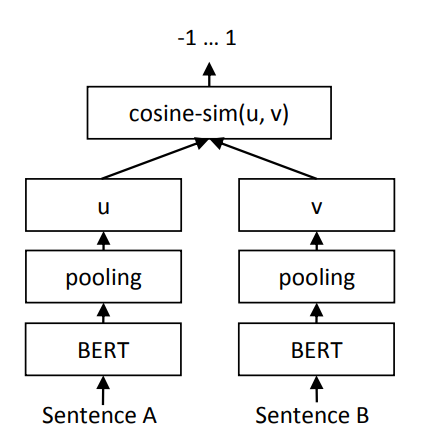

In [1]:
from transformers import BertTokenizer, BertModel
import torch

In [2]:
model_name = 'E:\\Visual Code Projects\\DL Starter\\RoBERTa Example\\models\\chinese-roberta-wwm'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at E:\Visual Code Projects\DL Starter\RoBERTa Example\models\chinese-roberta-wwm were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
sentences = [
    "求最好玩的角色扮演游戏",
    "求好玩的角色扮演游戏",
    "怎么加亲情号",
    "亲情卡怎么写"
]

In [4]:
# initialize dictionary to store tokenized sentences
tokens = {'input_ids': [], 'attention_mask': []}

for sentence in sentences:
    # encode each sentence and append to dictionary
    new_tokens = tokenizer.encode_plus(sentence, max_length=128,
                      truncation=True, padding='max_length',
                      return_tensors='pt')
    tokens['input_ids'].append(new_tokens['input_ids'][0])
    tokens['attention_mask'].append(new_tokens['attention_mask'][0])

# reformat list of tensors into single tensor
tokens['input_ids'] = torch.stack(tokens['input_ids'])
tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

In [5]:
outputs = model(**tokens)
embeddings = outputs.last_hidden_state
embeddings.shape

torch.Size([4, 128, 768])

In [6]:
attention_mask = tokens['attention_mask']
attention_mask.shape

torch.Size([4, 128])

In [7]:
mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
mask.shape

torch.Size([4, 128, 768])

In [8]:
masked_embeddings = embeddings * mask
masked_embeddings.shape

torch.Size([4, 128, 768])

In [9]:
summed = torch.sum(masked_embeddings, 1)
summed.shape

torch.Size([4, 768])

In [10]:
summed_mask = torch.clamp(mask.sum(1), min=1e-9)
summed_mask.shape

torch.Size([4, 768])

In [11]:
mean_pooled = summed / summed_mask

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
mean_pooled = mean_pooled.detach().numpy()

In [14]:
cosine_similarity([mean_pooled[0]], [mean_pooled[1]])

array([[0.98858535]], dtype=float32)

In [15]:
cosine_similarity([mean_pooled[2]], [mean_pooled[3]])

array([[0.8235484]], dtype=float32)

In [16]:
cosine_similarity([mean_pooled[0]], [mean_pooled[2]])

array([[0.6151498]], dtype=float32)